In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import skimage.io as io
import random
from torch_geometric.data import Data

/public/home/jijh/micromamba/envs/gpu_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
import numpy as np

def extract_patches(image, cell_coords, patch_size=100):
    """
    Extract image patches centered on given cell coordinates.

    Parameters:
    image (numpy.ndarray): The input image from which patches are to be extracted.
    cell_coords (list of tuples): A list of (x, y) coordinates around which patches are to be extracted.
    patch_size (int, optional): The size of the square patches to be extracted. Default is 100.

    Returns:
    list of numpy.ndarray: A list of extracted image patches, all of the same size.

    Notes:
    - If a patch extends beyond the image border, it will be padded with zeros to match the specified patch size.
    """
    patches = []
    half_size = patch_size // 2
    h, w = image.shape[:2]
    different_shape_count = 0

    # Ensure the input image has 3 dimensions
    if len(image.shape) == 2:  # Grayscale image
        image = image[:, :, np.newaxis]

    for (x, y) in cell_coords:
        x, y = int(x), int(y)
        x_min, x_max = x - half_size, x + half_size
        y_min, y_max = y - half_size, y + half_size

        # Initialize the patch with zeros
        patch = np.zeros((patch_size, patch_size, image.shape[2]), dtype=image.dtype)

        # Calculate bounds for extracting the region from the image
        x_start = max(0, x_min)
        x_end = min(w, x_max)
        y_start = max(0, y_min)
        y_end = min(h, y_max)

        # Calculate where to place the extracted region in the patch
        patch_x_start = max(0, -x_min)
        patch_x_end = patch_x_start + (x_end - x_start)
        patch_y_start = max(0, -y_min)
        patch_y_end = patch_y_start + (y_end - y_start)

        # Assign the extracted region into the patch
        patch[patch_y_start:patch_y_end, patch_x_start:patch_x_end] = image[y_start:y_end, x_start:x_end]

        if patch.shape[:2] != (patch_size, patch_size):
            different_shape_count += 1

        patches.append(patch)

    print(f"Number of patches with different shapes before padding: {different_shape_count}")
    return patches


In [4]:
def seed_everything(seed=0):
    """Initialize random seeds for reproducibility."""
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    
# Set random seed for reproducibility
random_seed = 0
seed_everything(random_seed)

# Data Preparation

In [5]:
file_dir = "st_project/cellbin_analysis/spatial_variation/wx_data/"  # Directory containing the data files
files = os.listdir(file_dir)  # List all files in the directory
files = [i for i in files if i.endswith(".h5ad") and "month" in i]  # Filter files to include only those ending with ".h5ad" and containing "month"
file_paths = [os.path.join(file_dir, i) for i in files]  # Create full file paths for the filtered files
adatas = {}  # Initialize an empty dictionary to store AnnData objects

# Read each file and store the AnnData object in the dictionary
for i in range(len(file_paths)):
    adatas[files[i].split(".")[0]] = sc.read(file_paths[i])

# Preprocess each AnnData object
for key in adatas.keys():
    sc.pp.normalize_total(adatas[key], target_sum=1e4)  # Normalize counts per cell
    sc.pp.log1p(adatas[key])  # Logarithmize the data
    sc.pp.scale(adatas[key])  # Scale the data to unit variance

In [6]:
# Extract spatial coordinates for each cell
cell_coords = {}
for key in adatas.keys():
    cell_coords[key] = adatas[key].obsm["spatial"].copy()
    
# Calculate the neighborhood graph
for key in adatas.keys():
    sc.pp.neighbors(adatas[key], n_neighbors=15, use_rep="spatial", random_state=random_seed)
    
# Extract the spatial neighbors
neighbors = {}
for key in adatas.keys():
    neighbors[key] = adatas[key].obsp["connectivities"].copy()

In [7]:

# Load the plaque dataset
img_dir = "st_project/cellbin_analysis/spatial_variation/wx_data/protein_seg_result/"
img_files = os.listdir(img_dir)
img_files = [i for i in img_files if i.endswith(".tiff") and "plaque" in i]
# Read the images

imgs = {}
for i in range(len(img_files)):
    imgs[img_files[i].split(".")[0]] = io.imread(os.path.join(img_dir, img_files[i]))
imgs.keys()
# Rename the imgs to match the adata keys
for key in list(imgs.keys()):
    parts = key.split("_")
    if len(parts) > 1:
        new_key = parts[1] + "_" + parts[2]
        imgs[new_key] = imgs.pop(key)



In [8]:
# Extract patches from the images
patches = {}
for key in imgs.keys():
    patches[key] = extract_patches(imgs[key], cell_coords[key], patch_size=128)

# Extract the positive patches
positive_patches = {}
for key in patches.keys():
    pos_list = []
    for i in range(len(patches[key])):
        if np.sum(patches[key][i]) > 0:
            pos_list.append(patches[key][i])
    positive_patches[key] = pos_list

# Convert the patches to binary and calculate the area of positive pixels for each patch
binary_patches = {}
for key in patches.keys():
    binary_patches[key] = [patch > 0 for patch in patches[key]]
# Calculate the area of positive pixels for each patch
areas = {}
for key in binary_patches.keys():
    areas[key] = [np.sum(patch) for patch in binary_patches[key]]

Number of patches with different shapes before padding: 0
Number of patches with different shapes before padding: 0
Number of patches with different shapes before padding: 0
Number of patches with different shapes before padding: 0


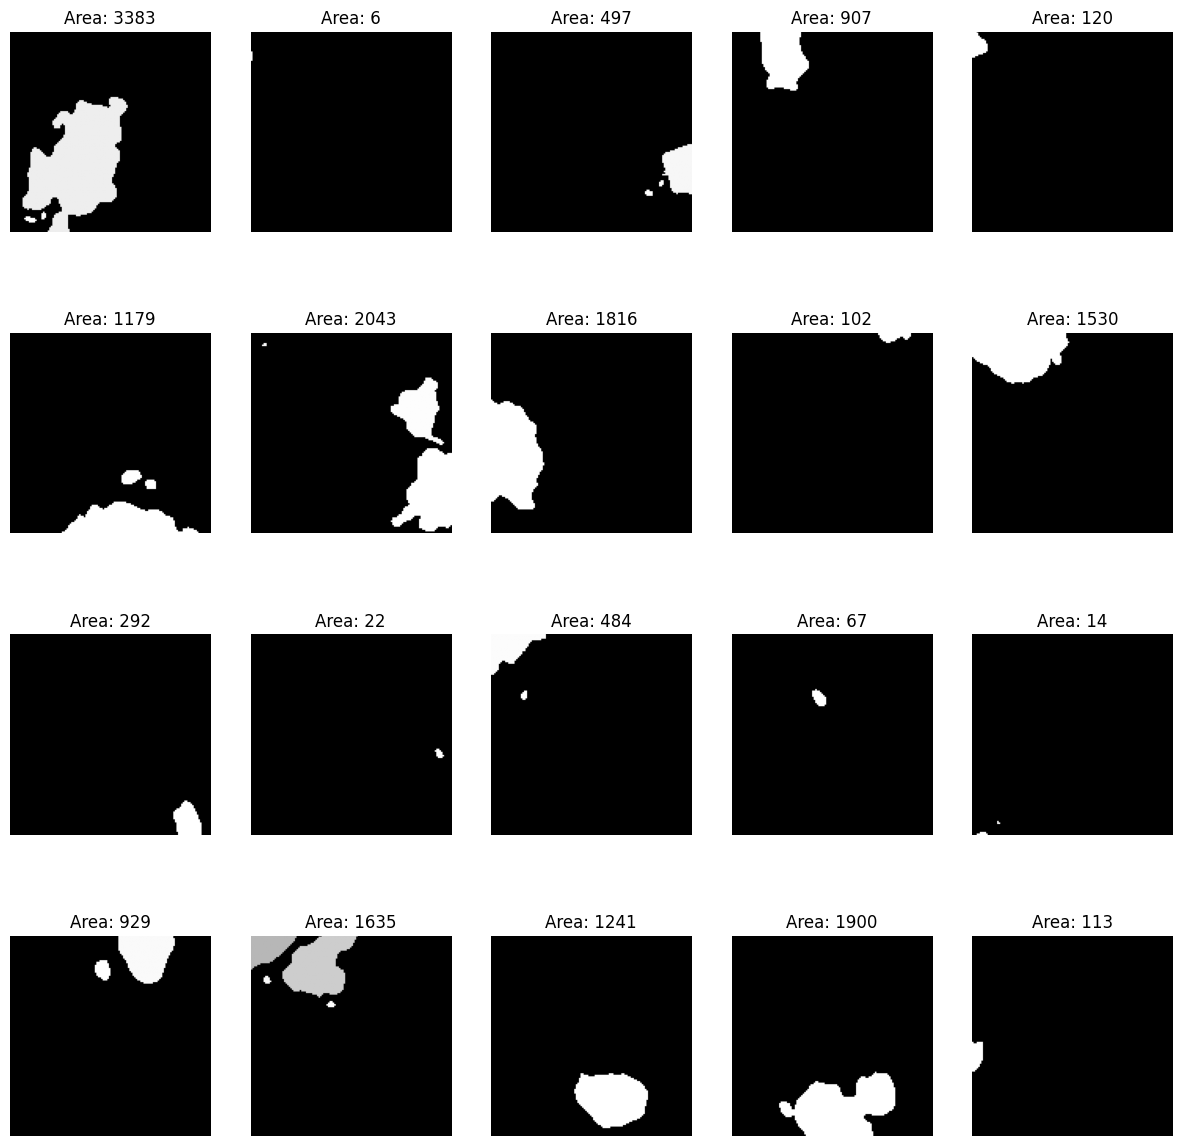

In [9]:
# Choose 5 patches with non-zero area for each image and plot them
import matplotlib.pyplot as plt

# Set the number of patches to plot
n_patches = 5

# Plot the patches
fig, axes = plt.subplots(nrows=len(areas), ncols=n_patches, figsize=(15, 15))
axes = np.atleast_2d(axes)  # Ensure axes is 2D for consistent indexing

for i, key in enumerate(areas.keys()):
    non_zero_indices = np.where(np.array(areas[key]) > 0)[0]
    chosen_indices = random.sample(list(non_zero_indices), n_patches)
    for j, idx in enumerate(chosen_indices):
        axes[i, j].imshow(patches[key][idx], cmap="gray")
        axes[i, j].set_title(f"Area: {areas[key][idx]}")
        axes[i, j].axis("off")
    axes[i, 0].set_ylabel(key, rotation=0, size="large", labelpad=50)

## Graph Construction

In [10]:
import torch
import scipy.sparse
from torch_geometric.data import Data
import numpy as np
from tqdm import tqdm

def create_graph_data_dict(adatas, areas, neighbors, cell_coords):
    """
    Create a dictionary of PyTorch Geometric Data objects from AnnData objects.
    
    Parameters:
    - adatas: dict of AnnData objects
    - areas: dict of patch areas
    - neighbors: dict of connectivity matrices
    - cell_coords: dict of spatial coordinates
    
    Returns:
    - graph_data_dict: dict of PyTorch Geometric Data objects
    """
    graph_data_dict = {}

    for key in tqdm(adatas.keys(), desc="Creating graph data"):
        # Ensure the keys match between adata and patches
        if key not in areas:
            print(f"Warning: No patch area data for {key}. Skipping.")
            continue

        adata = adatas[key]
        num_cells = adata.n_obs

        # Features: Gene expression data
        # Assuming 'X' is already a NumPy array after preprocessing
        features = adata.X
        if isinstance(features, scipy.sparse.csr_matrix):
            features = features.toarray()
        features = torch.tensor(features, dtype=torch.float)

        # Labels: Patch areas
        label_areas = areas[key]
        if len(label_areas) != num_cells:
            print(f"Warning: Number of patches and cells do not match for {key}.")
            # Handle mismatch, e.g., by trimming or padding
            min_len = min(len(label_areas), num_cells)
            label_areas = label_areas[:min_len]
            features = features[:min_len]

        labels = torch.tensor(label_areas, dtype=torch.float).unsqueeze(1)  # Shape: [num_nodes, 1]

        # Edges: Connectivity matrix
        connectivity = neighbors[key].tocoo()

        # Efficiently convert the edge matrix to tensor
        edge_index = torch.tensor(np.vstack([connectivity.row, connectivity.col]), dtype=torch.long)

        # Create PyTorch Geometric Data object
        data = Data(x=features, edge_index=edge_index, y=labels)

        # Optionally, add additional information (e.g., spatial coordinates)
        # spatial = torch.tensor(cell_coords[key], dtype=torch.float)
        # data.pos = spatial

        # Add to the dictionary
        graph_data_dict[key] = data

    return graph_data_dict


# Create the graph dictionary
graph_data_dict = create_graph_data_dict(adatas, areas, neighbors, cell_coords)


# Efficiently convert patches to tensors in batch
for key, graph in tqdm(graph_data_dict.items(), desc="Adding patches to graph data"):
    # Ensure patches[key] is a list of NumPy arrays
    patches_tensor = torch.tensor(np.array(patches[key]), dtype=torch.float)  # Convert patches to a single tensor efficiently
    graph.patches = patches_tensor



Adding patches to graph data: 100%|██████████| 4/4 [00:00<00:00,  5.91it/s]


In [11]:
graph_data_dict

{'8months-disease-replicate_1': Data(x=[8186, 2766], edge_index=[2, 131356], y=[8186, 1], patches=[8186, 128, 128, 1]),
 '13months-disease-replicate_1': Data(x=[10372, 2766], edge_index=[2, 167278], y=[10372, 1], patches=[10372, 128, 128, 1]),
 '8months-disease-replicate_2': Data(x=[8202, 2766], edge_index=[2, 132328], y=[8202, 1], patches=[8202, 128, 128, 1]),
 '13months-disease-replicate_2': Data(x=[9634, 2766], edge_index=[2, 155576], y=[9634, 1], patches=[9634, 128, 128, 1])}

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
device

device(type='cuda')

In [14]:
# Check system's gpu info
!nvidia-smi


Mon Dec 23 17:16:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100 PCIe               Off | 00000000:1F:00.0 Off |                    0 |
| N/A   30C    P0              50W / 350W |      3MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [15]:
torch.version.cuda

'12.4'

# Prediction & Represenation of the graph

In [16]:
data = graph_data_dict['8months-disease-replicate_1'].clone()

In [17]:
data

Data(x=[8186, 2766], edge_index=[2, 131356], y=[8186, 1], patches=[8186, 128, 128, 1])

In [18]:
# Binarize y: 1 if y > 0 else 0
data.y = (data.y > 0).float()


In [19]:
data = data.to(device)

In [20]:
# Example: random split (adjust to your scenario)
num_nodes = data.x.size(0)
perm = torch.randperm(num_nodes)
train_idx = perm[:int(0.8 * num_nodes)]
val_idx = perm[int(0.8 * num_nodes):int(0.9 * num_nodes)]
test_idx = perm[int(0.9 * num_nodes):]


In [21]:
import torch.nn as nn
from torch_geometric.nn import GCNConv, GraphSAGE

class GNNClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=1):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        self.lin = nn.Linear(hidden_channels, out_channels)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.lin(x)
        return x


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, global_mean_pool

class GNNClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=1, residual=True, dropout = 0.5):
        super().__init__()
        
        # -- GCN Layer --
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        
        # -- GraphSAGE Layer --
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)

        # Optional skip connection parameter
        self.residual = residual

        # -- Final MLP block --
        # You can expand or reduce the size/number of these layers based on your needs
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, out_channels)
        )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, batch=None):
        # --- First layer: GCN ---
        out1 = self.conv1(x, edge_index)
        out1 = self.bn1(out1)
        out1 = F.relu(out1)
        out1 = self.dropout(out1)
        
        # --- Second layer: GraphSAGE ---
        out2 = self.conv2(out1, edge_index)
        out2 = self.bn2(out2)
        out2 = F.relu(out2)
        out2 = self.dropout(out2)
        
        # --- Residual Connection (optional) ---
        if self.residual:
            out2 = out1 + out2  # Skip connection

        # If this is graph-level classification, pool over the nodes
        if batch is not None:
            out2 = global_mean_pool(out2, batch)
        
        # --- Final MLP ---
        out = self.mlp(out2)

        return out


In [23]:
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv

class GATClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=1, heads=32, dropout=0.5):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        # The output of the first GATConv layer will be hidden_channels * heads
        self.bn1 = nn.BatchNorm1d(hidden_channels * heads)
        
        # For the second GATConv layer, you can choose to concatenate heads or average them
        # Here, we set concat=False to average the heads
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=True, dropout=dropout)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        
        self.lin = nn.Linear(hidden_channels, out_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        # First GAT layer with multi-head attention
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        
        # Second GAT layer
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        
        # Final linear layer
        x = self.lin(x)
        return x


In [24]:
# Initialize and train the classifier
model = GNNClassifier(in_channels=data.x.size(1), hidden_channels=128, dropout=0.6).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Properly initialize the weights
def weights_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [25]:
def train_classifier():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index).squeeze()
    loss = criterion(out[train_idx], data.y[train_idx].view(-1))
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate_classifier(idx):
    model.eval()
    out = model(data.x, data.edge_index).squeeze()
    pred = (out.sigmoid() > 0.5).float()
    correct = (pred[idx] == data.y[idx].view(-1)).sum().item()
    acc = correct / idx.size(0)
    loss = criterion(out[idx], data.y[idx].view(-1)).item()
    return loss, acc




Training Epochs: 100%|██████████| 400/400 [00:04<00:00, 93.73it/s] 


Test Accuracy: 0.9414
Test AUC: 0.9641


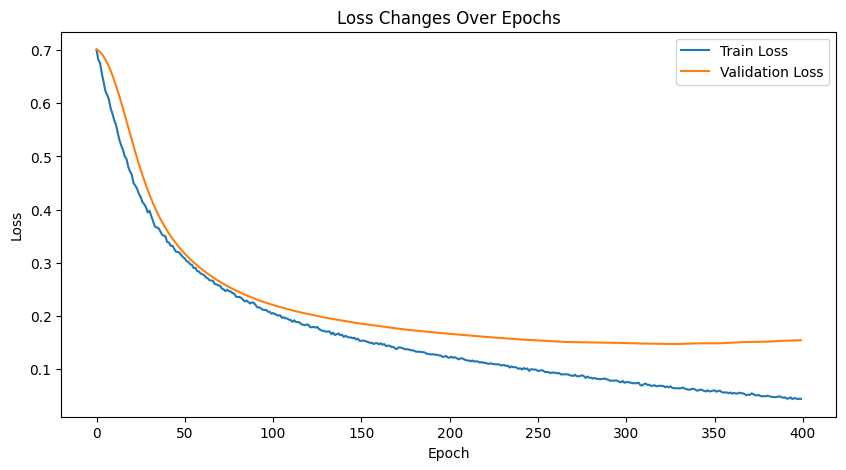

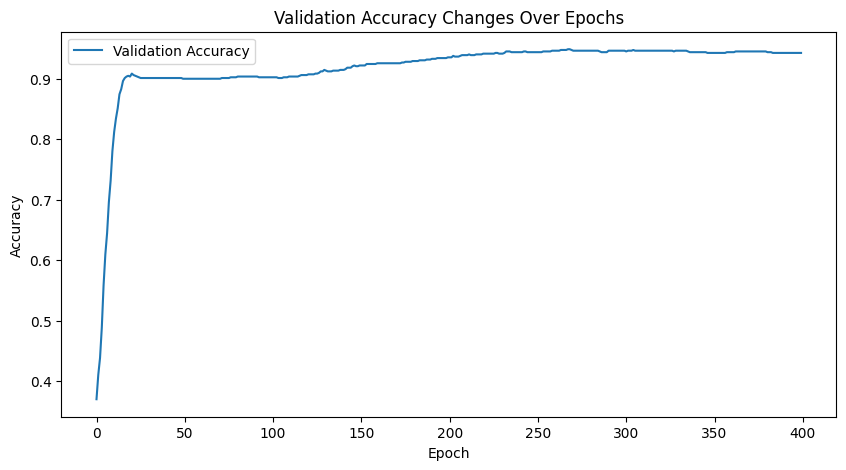

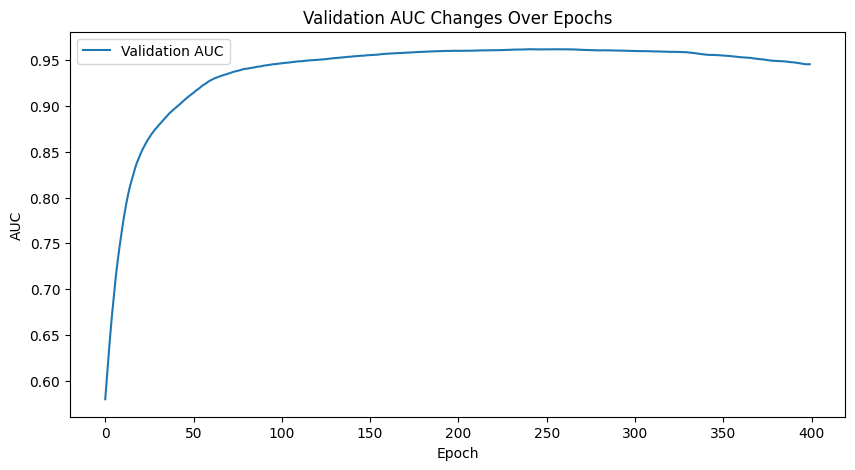

In [26]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

best_val_acc = 0.0
train_losses = []
val_losses = []
val_accuracies = []
val_aucs = []

for epoch in tqdm(range(400), desc="Training Epochs"):
    loss = train_classifier()
    val_loss, val_acc = evaluate_classifier(val_idx)
    train_losses.append(loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Calculate AUC for validation set
    model.eval()
    with torch.no_grad():
        val_logits = model(data.x, data.edge_index).squeeze()
        val_preds = val_logits.sigmoid()
        val_auc = roc_auc_score(data.y[val_idx].cpu(), val_preds[val_idx].cpu())
        val_aucs.append(val_auc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = model.state_dict()
    # Optional: print progress
    # print(f"Epoch {epoch:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}")

# Load the best model
model.load_state_dict(best_state)

test_loss, test_acc = evaluate_classifier(test_idx)
print(f"Test Accuracy: {test_acc:.4f}")

# Calculate AUC for test set
model.eval()
with torch.no_grad():
    test_logits = model(data.x, data.edge_index).squeeze()
    test_preds = test_logits.sigmoid()
    test_auc = roc_auc_score(data.y[test_idx].cpu(), test_preds[test_idx].cpu())
print(f"Test AUC: {test_auc:.4f}")

# Plot the loss changes
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Changes Over Epochs')
plt.show()

# Plot the validation accuracy changes
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy Changes Over Epochs')
plt.show()

# Plot the validation AUC changes
plt.figure(figsize=(10, 5))
plt.plot(val_aucs, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.title('Validation AUC Changes Over Epochs')
plt.show()

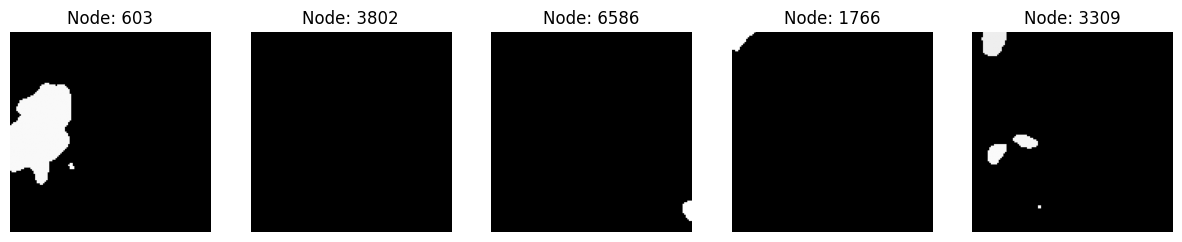

In [27]:
# Get predictions from the classifier
model.eval()
with torch.no_grad():
    logits = model(data.x, data.edge_index).squeeze()
    preds = (logits.sigmoid() > 0.5).float()

# Identify positive nodes
positive_nodes = (preds == 1).nonzero(as_tuple=True)[0]

# Visualize a subset of the positive nodes' patches images
num_images_to_plot = min(5, len(positive_nodes))  # Plot up to 5 images
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 5))
axes = np.atleast_1d(axes)

# Randomly select positive nodes to plot
random_positive_nodes = random.sample(list(positive_nodes), num_images_to_plot)

for i, node in enumerate(random_positive_nodes):
    patch = data.patches[node].squeeze().to("cpu").numpy()
    axes[i].imshow(patch, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Node: {node.item()}")
plt.show()


# Attention Autoencoder

In [189]:
graph_data_dict

{'8months-disease-replicate_1': Data(x=[8186, 2766], edge_index=[2, 131356], y=[8186, 1], patches=[8186, 128, 128, 1]),
 '13months-disease-replicate_1': Data(x=[10372, 2766], edge_index=[2, 167278], y=[10372, 1], patches=[10372, 128, 128, 1]),
 '8months-disease-replicate_2': Data(x=[8202, 2766], edge_index=[2, 132328], y=[8202, 1], patches=[8202, 128, 128, 1]),
 '13months-disease-replicate_2': Data(x=[9634, 2766], edge_index=[2, 155576], y=[9634, 1], patches=[9634, 128, 128, 1])}

In [28]:
# Import transform functions from torchvision
from torchvision.transforms import transforms

# Create a dataset of only positive patches
class PositivePatchDataset(Dataset):
    def __init__(self, patches, device):
        self.patches = patches.to(device)
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
        ])

    def __len__(self):
        return self.patches.size(0)

    def __getitem__(self, idx):
        patch = self.patches[idx]  # [1,128,128]
        # Convert to PIL and back to tensor for augmentations
        patch_np = (patch.squeeze(0).cpu().numpy() * 255).astype(np.uint8)
        # Now apply transforms
        patch_pil = transforms.ToPILImage()(patch_np)
        patch_pil = self.transform(patch_pil)
        patch_tensor = transforms.ToTensor()(patch_pil).to(self.patches.device)  # [1,128,128], float in [0,1]
        return patch_tensor
    
# Filter for positive nodes
positive_patches_sample = data.patches[positive_nodes].permute(0, 3, 1, 2)  # [num_positive, 1, 128, 128]

positive_dataset = PositivePatchDataset(positive_patches_sample, device)
plaque_loader = DataLoader(positive_dataset, batch_size=32, shuffle=True)


In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        # Channel Attention Module
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )
        # Spatial Attention Module
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # Channel Attention
        ca = self.channel_attention(x)
        x = x * ca
        # Spatial Attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        sa = self.spatial_attention(torch.cat([avg_out, max_out], dim=1))
        x = x * sa
        return x


In [30]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.0, transpose=False):
        super(ResidualBlock, self).__init__()
        self.transpose = transpose
        self.stride = stride

        # Define the shortcut connection
        if in_channels != out_channels or stride != 1:
            if not transpose:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(out_channels)
                )
            else:
                self.shortcut = nn.Sequential(
                    nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=stride,
                                       output_padding=stride-1, bias=False),
                    nn.BatchNorm2d(out_channels)
                )
        else:
            self.shortcut = nn.Identity()

        # Define the main residual path
        if not transpose:
            self.res_block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.SiLU(inplace=True),
                nn.Dropout(dropout),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.res_block = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1,
                                   output_padding=stride-1),
                nn.BatchNorm2d(out_channels),
                nn.SiLU(inplace=True),
                nn.Dropout(dropout),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        shortcut = self.shortcut(x)
        out = self.res_block(x)
        out += shortcut
        return F.relu(out, inplace=True)


In [31]:
class Encoder(nn.Module):
    def __init__(self, latent_channels=128, in_channels=1, dropout=0.5):
        super(Encoder, self).__init__()
        self.block1 = ResidualBlock(in_channels, 32, stride=2, dropout=dropout)
        self.cbam1 = CBAM(32)
        self.block2 = ResidualBlock(32, 64, stride=2, dropout=dropout)
        self.cbam2 = CBAM(64)
        self.block3 = ResidualBlock(64, 128, stride=2, dropout=dropout)
        self.cbam3 = CBAM(128)
        self.block4 = ResidualBlock(128, 256, stride=2, dropout=dropout)
        self.cbam4 = CBAM(256)
        
        # Convolutional layer for latent representation
        self.conv_latent = nn.Conv2d(256, 2 * latent_channels, kernel_size=3, stride=1, padding=1)
        
        # Parameters initialization
        self.latent_channels = latent_channels
    
    def forward(self, x):
        x = self.block1(x)
        x = self.cbam1(x)
        x = self.block2(x)
        x = self.cbam2(x)
        x = self.block3(x)
        x = self.cbam3(x)
        x = self.block4(x)
        x = self.cbam4(x)
        latent = self.conv_latent(x)
        
        # Split the latent representation into mu and logvar along the channels dimension
        mu, logvar = torch.chunk(latent, 2, dim=1)
        return mu, logvar


In [32]:
class Decoder(nn.Module):
    def __init__(self, latent_channels=128, out_channels=1, dropout=0.5):
        super(Decoder, self).__init__()
        self.block1 = ResidualBlock(latent_channels, 256, stride=2, dropout=dropout, transpose=True)
        self.cbam1 = CBAM(256)
        self.block2 = ResidualBlock(256, 128, stride=2, dropout=dropout, transpose=True)
        self.cbam2 = CBAM(128)
        self.block3 = ResidualBlock(128, 64, stride=2, dropout=dropout, transpose=True)
        self.cbam3 = CBAM(64)
        self.block4 = ResidualBlock(64, 32, stride=2, dropout=dropout, transpose=True)
        self.cbam4 = CBAM(32)
        
        # Final convolution to get the output
        self.final_conv = nn.Sequential(
            nn.Conv2d(32, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, z, target_shape=None):
        z = self.block1(z)
        z = self.cbam1(z)
        z = self.block2(z)
        z = self.cbam2(z)
        z = self.block3(z)
        z = self.cbam3(z)
        z = self.block4(z)
        z = self.cbam4(z)
        x = self.final_conv(z)
        
        # Optional: Resize to target shape if provided
        if target_shape is not None:
            x = F.interpolate(x, size=target_shape[2:], mode='bilinear', align_corners=False)
        return x


In [33]:
class VAE(nn.Module):
    def __init__(self, latent_channels=128, in_channels=1, out_channels=1, dropout=0.25):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_channels, in_channels, dropout)
        self.decoder = Decoder(latent_channels, out_channels, dropout)
    
    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from N(0,1).
        """
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn_like(std)    # Epsilon ~ N(0,1)
        return mu + eps * std          # Sampled latent vector
    
    def forward(self, x):
        mu, logvar = self.encoder(x)    # Encode input to latent space
        z = self.reparameterize(mu, logvar)  # Sample from latent space
        recon_x = self.decoder(z, target_shape=x.shape)  # Decode to reconstruct
        return recon_x, mu, logvar


In [34]:
def vae_loss(recon_x, x, mu, logvar, epoch, total_epochs):
    """
    Computes the VAE loss function as the sum of reconstruction loss and KL divergence.

    Args:
        recon_x (torch.Tensor): Reconstructed image.
        x (torch.Tensor): Original input image.
        mu (torch.Tensor): Mean from the encoder's latent space.
        logvar (torch.Tensor): Log variance from the encoder's latent space.
        epoch (int): Current epoch number.
        total_epochs (int): Total number of training epochs.

    Returns:
        torch.Tensor: Combined loss.
    """
    # Linearly increase the weight of KL divergence (optional)
    kl_weight = min(1.0, epoch / total_epochs)
    
    # Reconstruction loss: Binary Cross-Entropy
    # Change 'reduction' to 'mean' for average per pixel loss
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='mean')
    
    # KL Divergence loss: Sum over all elements
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss
    total_loss = recon_loss + kl_weight * kl_loss
    return total_loss


In [35]:
def train_vae(vae, dataloader, optimizer, epochs=30, device=device, patience=4, clip_value=5.0, scheduler=None, verbose=True):
    """
    Trains the VAE model with integrated CBAM attention mechanisms.

    Args:
        vae (nn.Module): The VAE model to train.
        dataloader (DataLoader): DataLoader for the training data.
        optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
        epochs (int, optional): Number of training epochs. Defaults to 30.
        device (torch.device, optional): Device to train on. Defaults to device.
        patience (int, optional): Number of epochs with no improvement after which training will be stopped. Defaults to 4.
        clip_value (float, optional): Maximum gradient norm for clipping. Defaults to 5.0.
        scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler. Defaults to None.
        verbose (bool, optional): If True, prints training progress. Defaults to True.

    Returns:
        nn.Module: Trained VAE model.
        list: History of average losses per epoch.
    """
    vae.to(device)
    vae.train()
    loss_history = []
    best_loss = float('inf')
    patience_counter = 0
    best_state = None  # Initialize best_state

    for epoch in range(1, epochs + 1):
        train_loss = 0.0
        count = 0
        progress_bar = tqdm(dataloader, desc=f"VAE Epoch {epoch}/{epochs}", leave=False) if verbose else dataloader

        for batch in progress_bar:
            # If your DataLoader returns a tuple (data, labels), adjust accordingly
            # Assuming batch is the input data
            batch = batch.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(batch)
            loss = vae_loss(recon_batch, batch, mu, logvar, epoch, epochs)
            loss.backward()
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(vae.parameters(), clip_value)
            optimizer.step()
            train_loss += loss.item()
            count += 1
            if verbose:
                progress_bar.set_postfix({'Batch Loss': loss.item() / batch.size(0)})

        # Optional: Step the scheduler if provided
        if scheduler is not None:
            scheduler.step()

        # Compute average loss per sample
        avg_loss = train_loss / len(dataloader.dataset)
        if verbose:
            print(f"VAE Epoch {epoch}, Average Loss: {avg_loss:.4f}")
        loss_history.append(avg_loss)

        # Early Stopping Check
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            best_state = vae.state_dict()
            if verbose:
                print(f"  New best loss: {best_loss:.4f}")
        else:
            patience_counter += 1
            if verbose:
                print(f"  No improvement. Patience counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                if verbose:
                    print("VAE Early stopping triggered")
                break

    # Load the best model state
    if best_state is not None:
        vae.load_state_dict(best_state)
        if verbose:
            print("Loaded the best model state based on validation loss.")
    else:
        if verbose:
            print("No improvement during training.")

    return vae, loss_history


VAE Epoch 1, Average Loss: 0.0110
  New best loss: 0.0110


VAE Epoch 2, Average Loss: 0.0017
  New best loss: 0.0017


VAE Epoch 3, Average Loss: 0.0011
  New best loss: 0.0011


VAE Epoch 4, Average Loss: 0.0010
  New best loss: 0.0010


VAE Epoch 5, Average Loss: 0.0009
  New best loss: 0.0009


VAE Epoch 6, Average Loss: 0.0009
  New best loss: 0.0009


VAE Epoch 7, Average Loss: 0.0009
  New best loss: 0.0009


VAE Epoch 8, Average Loss: 0.0009
  New best loss: 0.0009


VAE Epoch 9, Average Loss: 0.0009
  New best loss: 0.0009


VAE Epoch 10, Average Loss: 0.0009
  New best loss: 0.0009


VAE Epoch 11, Average Loss: 0.0008
  New best loss: 0.0008


VAE Epoch 12, Average Loss: 0.0008
  New best loss: 0.0008


VAE Epoch 13, Average Loss: 0.0008
  New best loss: 0.0008


VAE Epoch 14, Average Loss: 0.0008
  New best loss: 0.0008


VAE Epoch 15, Average Loss: 0.0008
  No improvement. Patience counter: 1/3


VAE Epoch 16, Average Loss: 0.0008
  No improvement. Patience counter: 2/3


VAE Epoch 17, Average Loss: 0.0008
  No improvement. Patience counter: 3/3
VAE Early stopping triggered
Loaded the best model state based on validation loss.


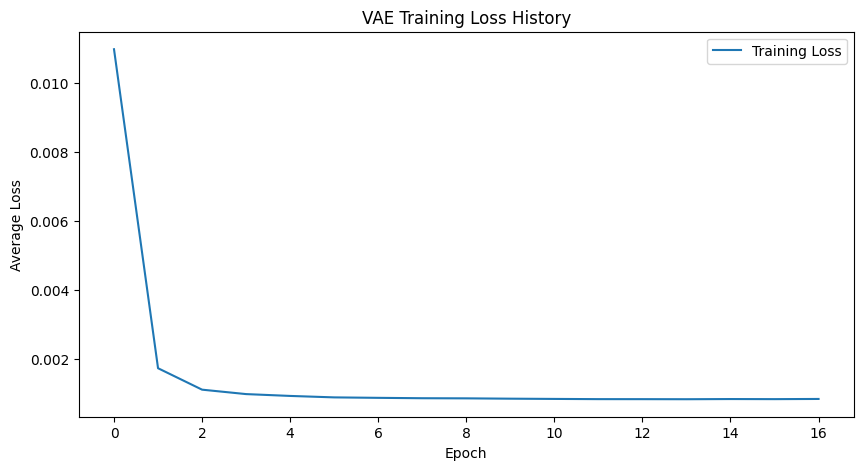

In [36]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR  # Example scheduler

# Instantiate the VAE
vae = VAE(latent_channels=128, in_channels=1, out_channels=1, dropout=0.25)

# Define the optimizer
optimizer_vae = Adam(vae.parameters(), lr=1e-3)

# (Optional) Define a learning rate scheduler
scheduler = StepLR(optimizer_vae, step_size=10, gamma=0.1)

# Assuming you have a DataLoader `train_loader`
# For example:
# from torchvision import datasets, transforms
# transform = transforms.Compose([transforms.ToTensor()])
# train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Train the VAE
trained_vae, loss_history = train_vae(
    vae=vae,
    dataloader=plaque_loader,
    optimizer=optimizer_vae,
    epochs=100,
    device=device,
    patience=3,
    clip_value=5.0,
    scheduler=scheduler,  # Pass the scheduler if you have one
    verbose=True
)

# Example: Plotting the loss history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('VAE Training Loss History')
plt.legend()
plt.show()


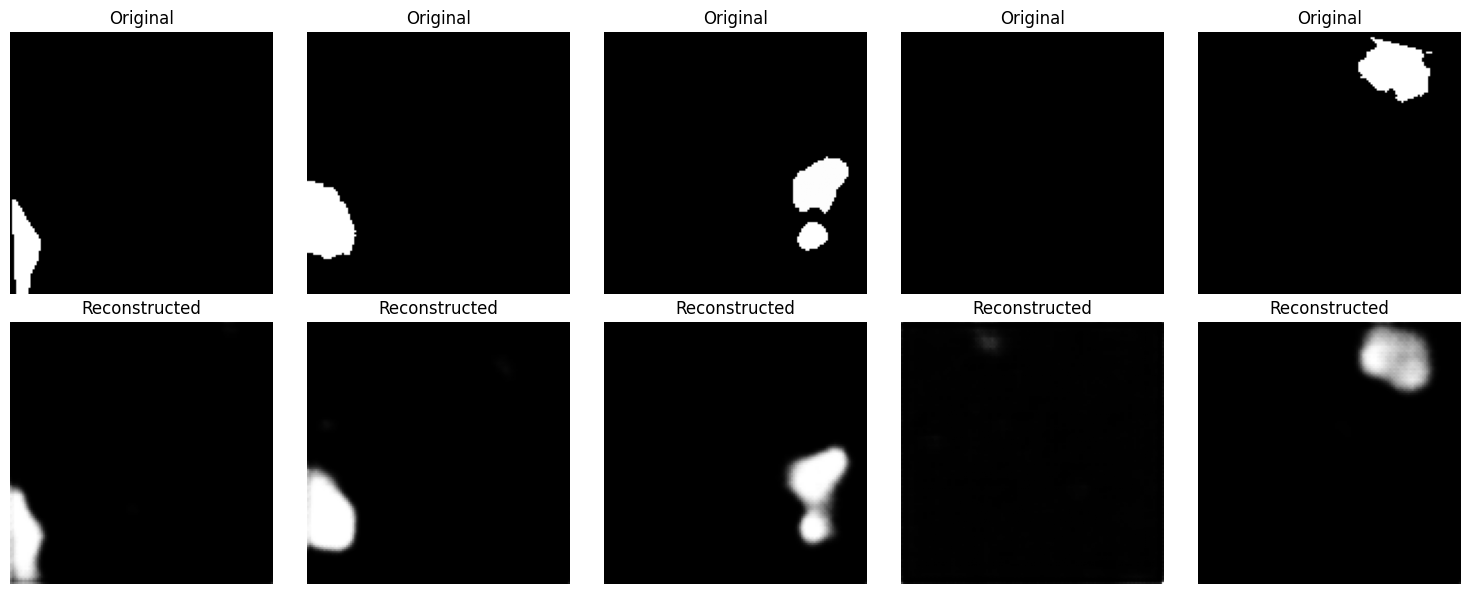

In [37]:
# Test the vae on a batch of positive patches
vae.eval()
with torch.no_grad():
    batch = next(iter(plaque_loader)).to(device)
    recon_batch, mu, logvar = vae(batch)
    recon_batch = recon_batch.cpu()

# Plot the original and reconstructed patches
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(5):
    axes[i].imshow(batch[i].squeeze().cpu(), cmap='gray')
    axes[i].set_title("Original")
    axes[i].axis('off')
    axes[i+5].imshow(recon_batch[i].squeeze(), cmap='gray')
    axes[i+5].set_title("Reconstructed")
    axes[i+5].axis('off')
plt.tight_layout()
plt.show()


# Latent Diffusion (Ran but failed)

In [203]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm

In [210]:
class LatentDiffusionModel(nn.Module):
    def __init__(self, vae, timesteps=1000, betas=(1e-4, 0.02)):
        super(LatentDiffusionModel, self).__init__()
        self.vae = vae  # Pre-trained VAE model
        self.timesteps = timesteps
        self.betas = torch.linspace(betas[0], betas[1], timesteps)  # Linear beta schedule

        # Compute alpha_t and alpha_bar_t from betas
        self.alpha_t = 1.0 - self.betas  # alpha_t = 1 - beta_t
        self.alpha_bar_t = torch.cumprod(self.alpha_t, dim=0)  # Cumulative product of alpha_t

        # Denoising UNet Model
        self.denoising_unet = nn.Sequential(
            nn.Conv2d(vae.encoder.latent_channels, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, vae.encoder.latent_channels, kernel_size=3, padding=1)
        )

    def forward(self, x, t):
        """
        Perform a forward diffusion step for timestep t.
        """
        device = x.device  # Get the device of input x
        t = t.to(device)   # Move t to the same device as x

        # Get latent representation from the VAE encoder
        z = self.vae.encoder(x)[0]
        z = z.to(device)  # Ensure z is on the same device as x

        # Ensure that alpha_bar_t[t] is broadcasted to the correct shape and on the same device as x
        alpha_bar_t = self.alpha_bar_t.to(device)[t].view(-1, 1, 1, 1).expand_as(z)

        # Generate noise
        noise = torch.randn_like(z).to(device)

        # Add noise to the latent representation (forward diffusion)
        z_t = torch.sqrt(alpha_bar_t) * z + torch.sqrt(1 - alpha_bar_t) * noise
        return z_t

    def reverse_diffusion(self, z_t, t):
        """
        Perform a reverse diffusion step.
        """
        denoised = self.denoising_unet(z_t)
        # Use the denoising UNet to predict the clean latent representation at this timestep
        z_pred = z_t - denoised  # This is a simplified reverse pass
        return z_pred

    def sample(self, shape):
        """
        Sample from the latent space, starting from noise.
        """
        # Sample initial noise in latent space
        z_t = torch.randn(shape).to(device)
        for t in range(self.timesteps-1, -1, -1):
            z_t = self.reverse_diffusion(z_t, t)
        return z_t

    def reconstruct(self, z_t):
        """
        Reconstruct the image from the denoised latent representation.
        """
        return self.vae.decoder(z_t)

def train_latent_diffusion_model(vae, dataset, num_epochs=100, batch_size=32, lr=1e-4, timesteps=1000, patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize the Latent Diffusion Model
    ldm = LatentDiffusionModel(vae, timesteps=timesteps)
    ldm.to(device)
    
    # DataLoader
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Optimizer
    optimizer = optim.Adam(ldm.parameters(), lr=lr)

    # Training loop
    losses = []
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in tqdm(range(num_epochs), desc="Training Epochs", ncols=100):
        ldm.train()
        running_loss = 0.0
        for batch_idx, data in enumerate(data_loader):
            data = data.to(device)  # move data to device (GPU/CPU)

            # Random timestep for each image in the batch
            t = torch.randint(0, timesteps, (data.size(0),), device=device)

            # Forward pass: Diffuse the data
            z_t = ldm.forward(data, t)
            
            # Reverse diffusion pass (denoise)
            z_pred = ldm.reverse_diffusion(z_t, t)
            
            # Calculate loss (L2 loss between predicted and original latent)
            mu, logvar = vae.encoder(data)
            loss = F.mse_loss(z_pred, mu)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            # Clean up memory after each batch
            del z_t, z_pred  # Delete intermediate variables to free memory
            torch.cuda.empty_cache()  # Clear the cache to prevent memory overflow

        avg_loss = running_loss / len(data_loader)
        losses.append(avg_loss)
        
        # Early stopping check
        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        if epoch % (num_epochs / 10) == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    return ldm, losses

def visualize_generated_images(ldm, num_images=8, image_size=(1, 128, 128)):
    """
    Generate images using Latent Diffusion Model (LDM) and visualize them.
    """
    # Adjust the latent channels if needed
    num_latent_channels = 128  # Ensure the latent space has the correct number of channels
    
    # Generate latent representations (with the expected number of channels)
    z_t_shape = (num_images, num_latent_channels, *image_size[1:])  # Define shape for random latent tensor
    
    # Use torch.no_grad() to disable gradient computation during inference
    with torch.no_grad():
        # Perform reverse diffusion to generate clean latent representations
        z_t = ldm.sample(z_t_shape)  # Pass shape, not tensor
        
        # Reconstruct images from latent representations
        generated_images = ldm.reconstruct(z_t)  # Reconstruct images
    
    # Move generated images to CPU for visualization
    generated_images = generated_images.cpu().detach()

    # Convert the images to numpy and normalize to [0, 1]
    generated_images = generated_images.squeeze(1)  # Remove channel dimension if it's 1
    generated_images = generated_images.clamp(0, 1).numpy()

    # Plot the generated images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        axes[i].imshow(generated_images[i], cmap='gray')
        axes[i].axis('off')  # Remove axis labels
    plt.show()

In [215]:
vae.to(device)  # Move VAE model to the same device
ldm = LatentDiffusionModel(vae, timesteps=100).to(device)  # Move LDM to the same device

# Assuming `positive_dataset` is your dataset and DataLoader is created
ldm, losses = train_latent_diffusion_model(vae, positive_dataset, num_epochs=200, batch_size=64, timesteps=100)


Training Epochs:   0%|▏                                             | 1/200 [00:00<02:22,  1.40it/s]

Epoch [1/200], Loss: 0.2563


Training Epochs:  10%|████▋                                        | 21/200 [00:15<02:07,  1.40it/s]

Epoch [21/200], Loss: 0.1926


Training Epochs:  20%|█████████▏                                   | 41/200 [00:29<01:53,  1.40it/s]

Epoch [41/200], Loss: 0.1737


Training Epochs:  30%|█████████████▋                               | 61/200 [00:43<01:39,  1.39it/s]

Epoch [61/200], Loss: 0.1820


Training Epochs:  40%|██████████████████▏                          | 81/200 [00:58<01:24,  1.40it/s]

Epoch [81/200], Loss: 0.1513


Training Epochs:  41%|██████████████████▍                          | 82/200 [00:59<01:25,  1.38it/s]

Early stopping at epoch 83


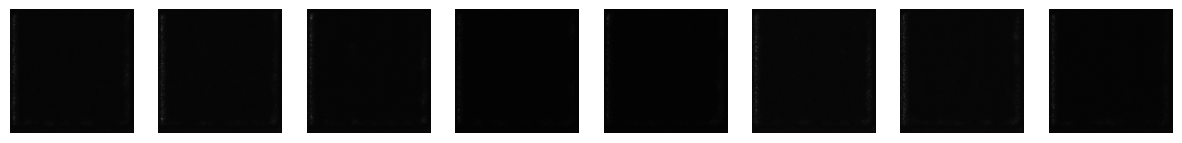

In [217]:
# Assuming ldm is your trained Latent Diffusion Model
visualize_generated_images(ldm, num_images=8, image_size=(1, 128, 128))


In [89]:
# Clean up all the cuda memory
torch.cuda.empty_cache()

# Save the trained models
torch.save(vae.state_dict(), "vae_model.pth")
torch.save(ldm.state_dict(), "ldm_model.pth")

In [88]:
import diffusers

# Try using diffusers

In [173]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "diffusion_project/diffusers_trial"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

In [174]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [175]:
model

UNet2DModel(
  (conv_in): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

In [176]:
model = model.to(device)

In [177]:
plaque_loader = DataLoader(positive_dataset, batch_size=config.train_batch_size, shuffle=True)

In [178]:
positive_patches_sample[0].shape

torch.Size([1, 128, 128])

In [179]:
sample_image = positive_patches_sample[100].unsqueeze(0).to(device)
print("Input shape:", sample_image.shape)
print("Output shape:", model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 1, 128, 128])
Output shape: torch.Size([1, 1, 128, 128])


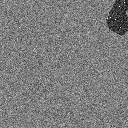

In [180]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape).to(device)
timesteps = torch.LongTensor([50]).to(device)
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).cpu().numpy()[0].squeeze(2))

In [181]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [182]:
loss

tensor(1.0571, device='cuda:0', grad_fn=<MseLossBackward0>)

## Train the model

In [183]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(plaque_loader) * config.num_epochs),
)

In [184]:
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.Generator(device=device).manual_seed(config.seed), # Use a separate torch generator to avoid rewinding the random state of the main training loop
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [187]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    loss_values = []  # Initialize a list to store loss values
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name, exist_ok=True
            ).repo_id
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)
                loss_values.append(loss.detach().item())  # Append the loss value

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

            plt.figure(figsize=(10, 6))
            plt.plot(loss_values, label="Loss")
            plt.xlabel("Steps")
            plt.ylabel("Loss")
            plt.title("Training Loss Curve")
            plt.legend()
            plt.grid()
            plt.show()

In [186]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, plaque_loader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Launching training on one GPU.


Epoch 49: 100%|██████████| 54/54 [00:43<00:00,  1.24it/s, loss=0.000166, lr=0, step=2699]


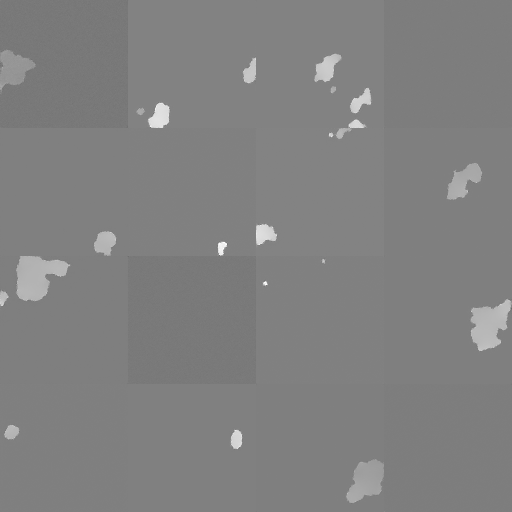

In [188]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

# Try training Latent Diffusion model using diffusers (can't use)

In [138]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm.auto import tqdm

from diffusers import UNet2DModel, DDPMScheduler
from accelerate import Accelerator

In [139]:
vae.eval().to(device)

# Freeze VAE parameters so we only train the diffusion model
for param in vae.parameters():
    param.requires_grad = False

In [140]:
latent_channels = 128
latent_size = 8  # height=width=8

diffusion_unet = UNet2DModel(
    sample_size=latent_size,       # 8
    in_channels=latent_channels,   # 128
    out_channels=latent_channels,  # 128
    block_out_channels=(128, 256, 256, 512),  # Increase capacity
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
).to(device)


In [141]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)


In [146]:
from diffusers.optimization import get_cosine_schedule_with_warmup

class DiffusionConfig:
    num_epochs = 50
    learning_rate = 5e-5
    lr_warmup_steps = 500
    gradient_accumulation_steps = 2
    mixed_precision = "fp16"
    output_dir = "./latent_diffusion_output"

config = DiffusionConfig()

optimizer_diffusion = AdamW(
    diffusion_unet.parameters(), 
    lr=5e-5  # Try lowering
)


# Optional LR scheduler
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer_diffusion,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=len(plaque_loader) * config.num_epochs,
)

accelerator = Accelerator(
    mixed_precision=config.mixed_precision,
    gradient_accumulation_steps=config.gradient_accumulation_steps,
    log_with="tensorboard",
    project_dir=os.path.join(config.output_dir, "logs"),
)

(diffusion_unet, optimizer_diffusion, plaque_loader, lr_scheduler) = accelerator.prepare(
    diffusion_unet, optimizer_diffusion, plaque_loader, lr_scheduler
)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [147]:
def train_latent_diffusion(
    vae, diffusion_unet, noise_scheduler, train_loader,
    optimizer, lr_scheduler, accelerator, config
):
    # VAE is frozen (pretrained)
    vae.eval()

    global_step = 0
    diffusion_unet.train()

    for epoch in range(config.num_epochs):
        progress_bar = tqdm(train_loader, disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch+1}/{config.num_epochs}")

        for step, batch in enumerate(progress_bar):
            # batch shape: [B, 1, 128, 128] if grayscale
            batch = batch.to(accelerator.device)

            # 1) Encode images into latents
            with torch.no_grad():
                mu, logvar = vae.encoder(batch)
                z = vae.reparameterize(mu, logvar)
                # z: [B, 128, 8, 8] (example)

            # 2) Sample random timesteps
            bsz = z.size(0)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=z.device).long()

            # 3) Add noise
            noise = torch.randn_like(z)
            noisy_z = noise_scheduler.add_noise(z, noise, timesteps)

            # 4) Predict noise with the UNet
            with accelerator.accumulate(diffusion_unet):
                noise_pred = diffusion_unet(noisy_z, timesteps).sample
                loss = F.mse_loss(noise_pred, noise)  # standard DDPM objective

                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(diffusion_unet.parameters(), 1.0)

                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.set_postfix({"loss": loss.item()})
            accelerator.log({"loss": loss.item(), "step": global_step}, step=global_step)
            global_step += 1

    return diffusion_unet


In [ ]:
args = (vae, diffusion_unet, noise_scheduler, plaque_loader, optimizer_diffusion, lr_scheduler, accelerator, config)

notebook_launcher(train_latent_diffusion, args, num_processes=1)

Launching training on one GPU.


Epoch 27/50:  89%|████████▉ | 48/54 [00:04<00:00, 11.32it/s, loss=0.667]

/public/home/jijh/micromamba/envs/gpu_env/lib/python3.12/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


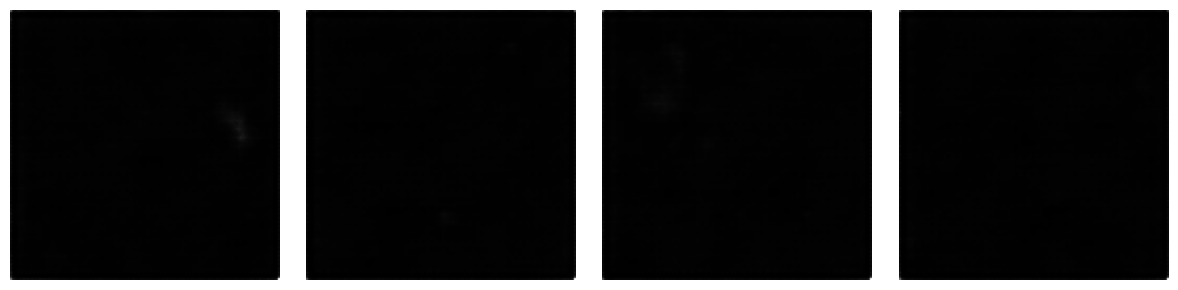

In [151]:
import matplotlib.pyplot as plt

def sample_latents(unet, scheduler, num_samples=4, latent_channels=128, latent_size=8, device="cuda"):
    unet.eval()
    latents = torch.randn(num_samples, latent_channels, latent_size, latent_size, device=device)
    with torch.no_grad():
        for t in range(scheduler.num_train_timesteps-1, -1, -1):
            timetensor = torch.tensor([t]*num_samples, device=device)
            noise_pred = unet(latents, timetensor).sample
            latents = scheduler.step(noise_pred, t, latents).prev_sample
    return latents

# Generate latents
sampled_latents = sample_latents(
    unet=trained_diffusion_unet,
    scheduler=noise_scheduler,
    num_samples=4,
    latent_channels=latent_channels,
    latent_size=latent_size,
    device=device
)

# Decode to pixel space
vae.eval()
with torch.no_grad():
    generated_images = vae.decoder(sampled_latents)  # shape [4, 1, 128, 128] if grayscale

# Visualize
fig, axes = plt.subplots(1, 4, figsize=(12,3))
for i in range(4):
    axes[i].imshow(generated_images[i, 0].cpu(), cmap='gray')
    axes[i].axis("off")
plt.tight_layout()
plt.show()


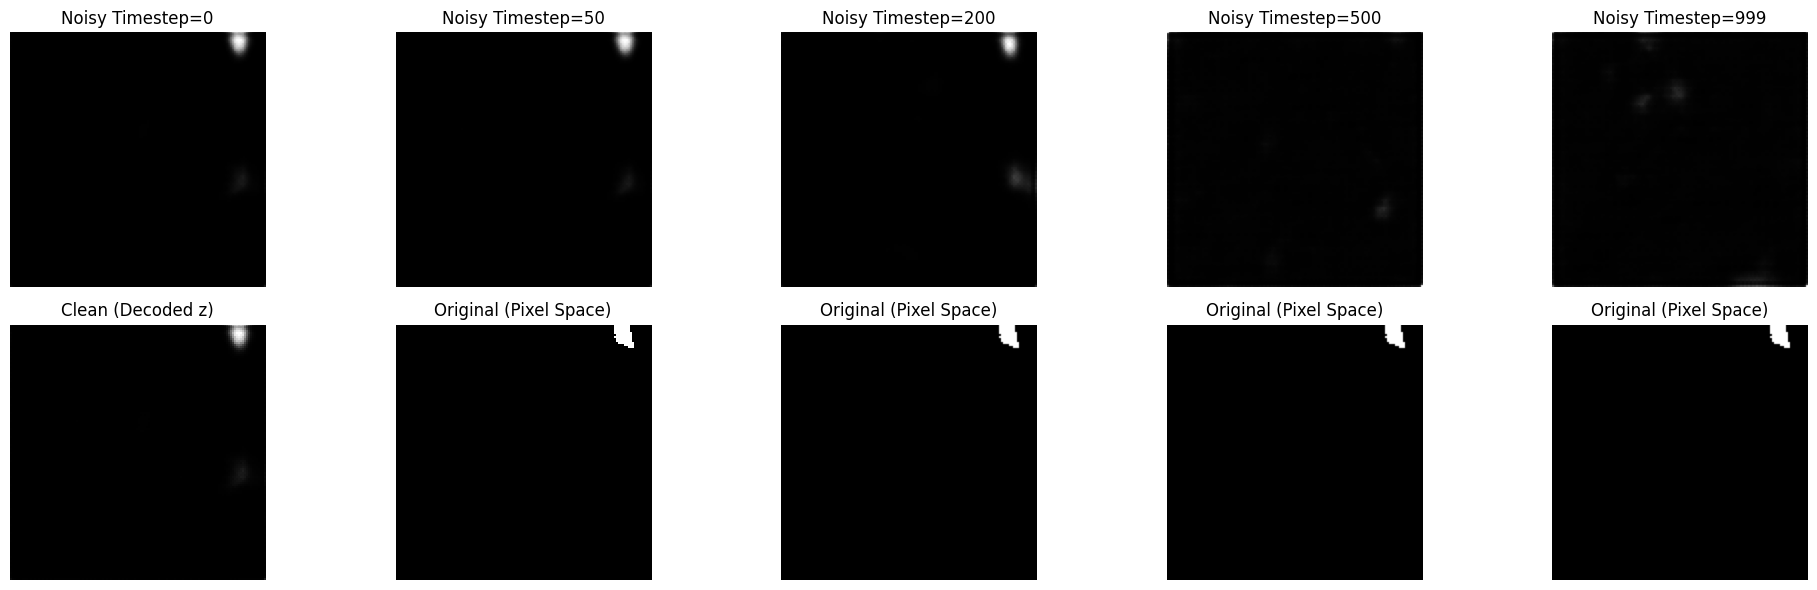

In [120]:
import torch
import matplotlib.pyplot as plt

def visualize_noise_in_latent_space(vae, noise_scheduler, data_loader, device, timesteps_list=[0, 50, 200, 500, 999]):
    """
    Demonstrates how images degrade at different noise levels in latent space.
    
    Args:
        vae: Pretrained VAE (frozen).
        noise_scheduler: DDPMScheduler or similar (with add_noise method).
        data_loader: DataLoader returning real images of shape [B, C, H, W].
        device: Torch device ('cuda' or 'cpu').
        timesteps_list: List of timesteps to illustrate.
    """
    # 1) Grab a small batch of real images
    batch = next(iter(data_loader))
    batch = batch.to(device)  # shape: [B, C, H, W] (e.g. [8, 1, 128, 128])

    # 2) Encode images into latent space
    vae.eval()
    with torch.no_grad():
        mu, logvar = vae.encoder(batch)
        z = vae.reparameterize(mu, logvar)
        # z shape might be [B, latent_channels, latent_height, latent_width]

    # We'll use the first image in the batch for illustration
    z_single = z[0].unsqueeze(0)  # shape [1, latent_channels, latent_height, latent_width]
    original_image = batch[0:1]   # shape [1, C, H, W]

    fig, axes = plt.subplots(2, len(timesteps_list), figsize=(4 * len(timesteps_list), 6))
    # First row: Noised images
    # Second row: Decoded images

    for i, timestep in enumerate(timesteps_list):
        # 3) Sample Gaussian noise
        noise = torch.randn_like(z_single)

        # 4) Add noise at a given timestep
        t_tensor = torch.tensor([timestep], device=device).long()
        z_noisy = noise_scheduler.add_noise(z_single, noise, t_tensor)

        # 5) Decode the noisy latent back to pixel space
        with torch.no_grad():
            decoded_noisy = vae.decoder(z_noisy)

        # Display noisy latent as an image:
        #   Actually, the "latent" itself is high-dimensional. So we can only decode
        #   it to pixel space or visualize a single channel. We'll visualize the decoded image.

        # Left: decode of original latent (if needed for reference)
        # Right: decode of z_noisy
        axes[0, i].imshow(decoded_noisy[0, 0].cpu(), cmap="gray")
        axes[0, i].set_title(f"Noisy Timestep={timestep}")
        axes[0, i].axis("off")

        # Compare with the *original* clean image for reference on second row
        if i == 0:
            # Original clean image on second row, first column
            with torch.no_grad():
                decoded_original = vae.decoder(z_single)
            axes[1, i].imshow(decoded_original[0, 0].cpu(), cmap="gray")
            axes[1, i].set_title("Clean (Decoded z)")
        else:
            axes[1, i].imshow(original_image[0, 0].cpu(), cmap="gray")
            axes[1, i].set_title("Original (Pixel Space)")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

# Usage:
visualize_noise_in_latent_space(vae, noise_scheduler, plaque_loader, device)
